## Import Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
from scipy import stats
import yfinance as yf

## Load in a set of Assets

In [6]:
# Example: portfolio construction with S&P 500 with gold, bitcoin, coffee and cocoa
assets = yf.download(['SPY', 'GLD','BTC-GBP','KC=F','CC=F'], start='2015-01-01', end='2025-01-01')['Close']

# Compute daily returns
returns = assets.pct_change().dropna()
returnslog = np.log(assets / assets.shift(1)).dropna()
returns.head()

# Annualized expected returns and covariance
mu = returns.mean() * 252
Sigma = returns.cov() * 252

returnslog.head()


C:\Users\andre\AppData\Local\Temp\ipykernel_40328\798475725.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  assets = yf.download(['SPY', 'GLD','BTC-GBP','KC=F','CC=F'], start='2015-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  5 of 5 completed
C:\Users\andre\AppData\Local\Temp\ipykernel_40328\798475725.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = assets.pct_change().dropna()


Ticker,BTC-GBP,CC=F,GLD,KC=F,SPY
Date,,,,,
2015-01-06,0.049758,-0.014369,0.011334,0.039655,-0.009464
2015-01-07,0.030189,0.003440,-0.005909,0.000857,0.012385
2015-01-08,-0.036721,0.025095,-0.004217,0.010513,0.017589
2015-01-09,0.019582,-0.006046,0.011321,0.017650,-0.008046
2015-01-13,-0.170240,-0.001003,-0.003379,0.001131,-0.002817


## Maximize a Sharpe Ratio (Analytically)

In [38]:
## Maximizing sharpe ration 
# Risk-free rate 
rf = 0.02

inv_Sigma = np.linalg.inv(Sigma)
ones = np.ones(len(mu))

# Tangency (max Sharpe) portfolio
excess_mu = mu - rf
w_tan = inv_Sigma @ excess_mu / (ones.T @ inv_Sigma @ excess_mu)

## normalize
w_tan /= w_tan.sum()

## show weights in portfolio
weights_df = pd.DataFrame({
    'Tangency': w_tan
}, index=mu.index)

## these are the weight allocations that support a max sharpe ratio on this data
print(weights_df)


C:\Users\andre\AppData\Local\Temp\ipykernel_101348\3487550803.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  assets = yf.download(['SPY', 'GLD','BTC-GBP','KC=F','CC=F'], start='2015-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  5 of 5 completed

         Tangency
Ticker           
BTC-GBP  0.211740
CC=F     0.175791
GLD      0.267466
KC=F     0.061400
SPY      0.283602



C:\Users\andre\AppData\Local\Temp\ipykernel_101348\3487550803.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = assets.pct_change().dropna()


## Test A Momentum Trading Strategy 

C:\Users\andre\AppData\Local\Temp\ipykernel_101348\1460367502.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()
C:\Users\andre\AppData\Local\Temp\ipykernel_101348\1460367502.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  signal = data.pct_change(window).shift(1)  # past return


Date
2015-01-13   -1.0
2015-01-14   -1.0
2015-01-15   -1.0
2015-01-16   -1.0
2015-01-17    1.0
             ... 
2024-12-27   -1.0
2024-12-28   -1.0
2024-12-29    1.0
2024-12-30    1.0
2024-12-31   -1.0
Freq: D, Name: SPY, Length: 3641, dtype: float64


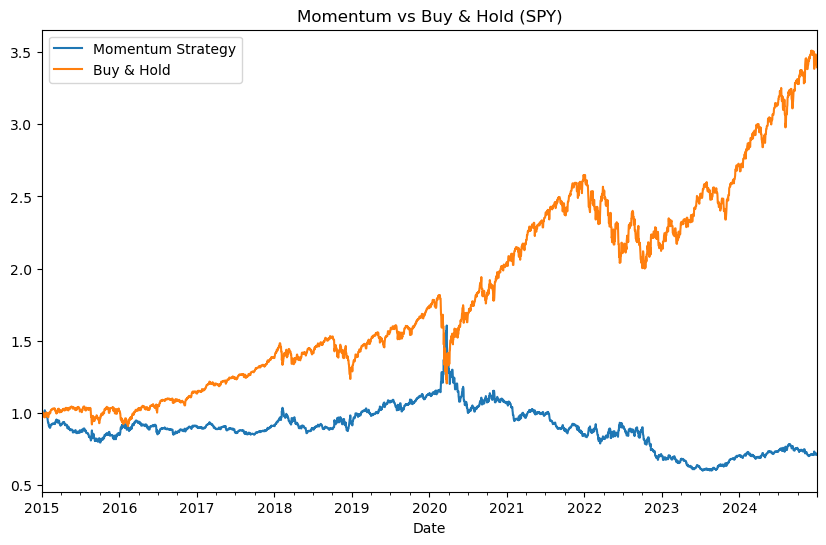

In [78]:
data = assets['SPY']

returns = data.pct_change().dropna()

window = 10  # lookback window in trading days
signal = data.pct_change(window).shift(1)  # past return

# Convert to a trading signal: +1 if momentum positive, −1 if negative
position = np.sign(signal)
print(position.dropna())

## returns are the position multiplied by the returns
strategy_returns = position*returns


#plot performance
(1 + strategy_returns).cumprod().plot(figsize=(10,6), label="Momentum Strategy")
(1 + returns).cumprod().plot(label="Buy & Hold")
plt.title("Momentum vs Buy & Hold (SPY)")
plt.legend()
plt.show()

## Test Seasonality

In [14]:
# First let's explore if monthly returns differe on average across assets. We can transform our data to an average monthly level

# Resample to monthly and compute total monthly change in proportional terms (last - first of each month)/first
monthly_change = (assets.resample('ME').last() - assets.resample('ME').first() ) / assets.resample('ME').first() 

# Add a indicator for monthh-end dates
monthly_change['Month'] = monthly_change.index.month

# Group by month and calculate statistics
monthly_change_avg = monthly_change.groupby('Month').mean()
monthly_change_std = monthly_change.groupby('Month').std()

import tabulate
def print_markdown_table(df, title):
    print(f"\n{title}\n")
    print(df.round(2).to_markdown(index=True))

# Display the results
print_markdown_table(monthly_change_avg, "### Average Monthly Change (bps)")


### Average Monthly Change (bps)

|   Month |   BTC-GBP |   CC=F |   GLD |   KC=F |   SPY |
|--------:|----------:|-------:|------:|-------:|------:|
|       1 |     -0.03 |  -0.01 |  0.02 |  -0    |  0.01 |
|       2 |      0.16 |   0.07 | -0    |  -0.01 | -0    |
|       3 |     -0.02 |   0.03 |  0.01 |  -0.02 | -0    |
|       4 |      0.08 |   0.03 |  0.01 |   0.02 |  0.02 |
|       5 |      0.09 |   0    |  0    |   0.02 |  0.01 |
|       6 |      0.03 |  -0.03 | -0    |  -0    |  0.01 |
|       7 |      0.1  |   0.01 |  0.02 |   0.03 |  0.03 |
|       8 |      0.02 |   0.05 |  0.01 |   0.02 |  0.01 |
|       9 |     -0.02 |  -0.03 | -0.02 |   0    | -0.01 |
|      10 |      0.2  |   0.01 |  0.01 |   0.01 |  0.01 |
|      11 |      0.07 |   0.06 | -0.02 |   0.07 |  0.04 |
|      12 |      0.1  |   0.01 |  0.01 |   0.02 | -0    |


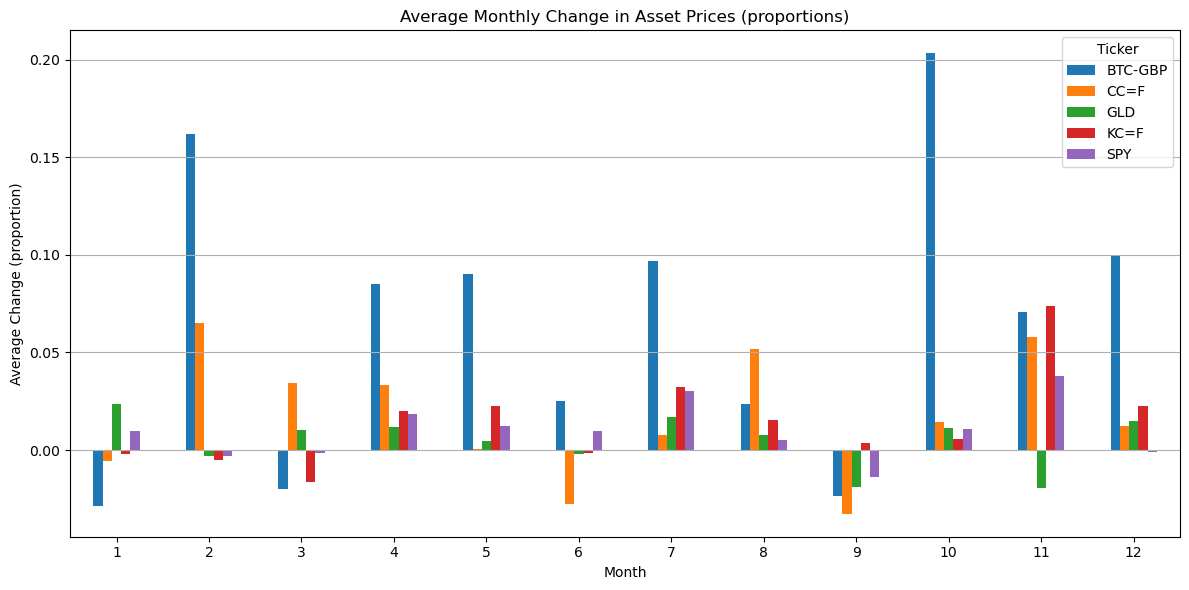

In [16]:
# next let's test whether there are particular patterns in monthly changes
monthly_change_avg.plot(kind='bar', figsize=(12, 6), title='Average Monthly Change in Asset Prices (proportions)')
plt.xlabel('Month')
plt.ylabel('Average Change (proportion)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [20]:
# for each asset, perform a statistical test to see if particular months are statistically significant in terms of returns relative to others

from scipy.stats import ttest_ind
import pandas as pd

# Prepare results list
results = []

# Loop through each asset and each month
for version in ['GLD','SPY']:
    for month in range(1, 13):
        # Get changes for the given month
        this_month = monthly_change[monthly_change['Month'] == month][version].dropna()
        # Get changes for all other months
        other_months = monthly_change[monthly_change['Month'] != month][version].dropna()

        # Perform Welch’s t-test (unequal variance)
        t_stat, p_value = ttest_ind(this_month, other_months, equal_var=False)

        results.append({
            'Asset': version,
            'Month': month,
            'Monthly Mean change': this_month.mean(),
            'T-Statistic': t_stat,
            'P-Value': p_value,
            'Significant (p < 0.05)': p_value < 0.05
        })

# Create DataFrame
ttest_df = pd.DataFrame(results)

# Round for readability
ttest_df = ttest_df.round({'Monthly Mean': 2, 'T-Statistic': 2, 'P-Value': 4})

# Sort by Asset and Month
ttest_df = ttest_df.sort_values(['Asset', 'Month'])

# Print full result
print(ttest_df.to_string(index=False))




Asset  Month  Monthly Mean change  T-Statistic  P-Value  Significant (p < 0.05)
  GLD      1             0.023529         1.63   0.1318                   False
  GLD      2            -0.002825        -0.47   0.6468                   False
  GLD      3             0.010494         0.57   0.5788                   False
  GLD      4             0.011900         0.76   0.4590                   False
  GLD      5             0.004443        -0.04   0.9681                   False
  GLD      6            -0.002077        -0.48   0.6400                   False
  GLD      7             0.017121         0.87   0.4042                   False
  GLD      8             0.007670         0.28   0.7820                   False
  GLD      9            -0.019093        -2.45   0.0313                    True
  GLD     10             0.011391         0.61   0.5568                   False
  GLD     11            -0.019326        -1.70   0.1191                   False
  GLD     12             0.014821       

In [56]:
## next let's test if trading on particular days is more or less successful 
data = assets[['SPY', 'GLD']]
data = data.asfreq('B').ffill()

# daily changes:
achg = np.log(data / data.shift(1)) * 100

# T-stats of mean != 0 for each day
def t_stats(x):
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    return x.mean() / (x.std(ddof=1) / np.sqrt(len(x)))

t_by_dom = achg.groupby(achg.index.day).agg(t_stats)


# counts for degrees of freedom
N_by_dom = achg.groupby(achg.index.day).count()

# Two sided p values with df = N - 1 per cell
p_by_dom = pd.DataFrame(index=t_by_dom.index, columns=t_by_dom.columns, dtype=float)
for col in t_by_dom.columns:
    tcol = t_by_dom[col]
    ncol = N_by_dom[col]
    p_by_dom[col] = 2 * stats.t.sf(np.abs(tcol), df=(ncol - 1))

# Stars helper
def stars(p):
    if pd.isna(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

stars_by_dom = p_by_dom.map(stars)

# Pretty p value table with stars appended
p_with_stars = p_by_dom.map(lambda p: f"{p:.4f}" if pd.notna(p) else "")
p_with_stars = p_with_stars + stars_by_dom

# Ensure the day-of-month is a visible first column
tbl_md = (
    p_with_stars
    .copy()
    .rename_axis("Day")           # name the index
    .reset_index()                # bring Day into a column
    .to_markdown(index=False)     # pretty Markdown table
)
print(tbl_md)



|   Day | SPY      | GLD       |
|------:|:---------|:----------|
|     1 | 0.2438   | 0.0068*** |
|     2 | 0.1183   | 0.9410    |
|     3 | 0.6397   | 0.2103    |
|     4 | 0.0782*  | 0.1391    |
|     5 | 0.9139   | 0.9912    |
|     6 | 0.2516   | 0.8759    |
|     7 | 0.4219   | 0.4847    |
|     8 | 0.1892   | 0.7615    |
|     9 | 0.6011   | 0.9672    |
|    10 | 0.1434   | 0.0707*   |
|    11 | 0.1841   | 0.7774    |
|    12 | 0.5243   | 0.6800    |
|    13 | 0.7486   | 0.2889    |
|    14 | 0.3960   | 0.2014    |
|    15 | 0.0228** | 0.8985    |
|    16 | 0.7244   | 0.8203    |
|    17 | 0.9105   | 0.7301    |
|    18 | 0.2719   | 0.4883    |
|    19 | 0.4351   | 0.6408    |
|    20 | 0.3777   | 0.0507*   |
|    21 | 0.9649   | 0.8456    |
|    22 | 0.5381   | 0.1960    |
|    23 | 0.7988   | 0.6580    |
|    24 | 0.9345   | 0.0375**  |
|    25 | 0.4020   | 0.0344**  |
|    26 | 0.3264   | 0.2578    |
|    27 | 0.6356   | 0.9554    |
|    28 | 0.2894   | 0.9670    |
|    29 | 